In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import gc

In [2]:
# Creating file path for our train data and test data
train_dir = "train"
test_dir = "test"
val_autistic = "valid/Autistic"
val_non_autistic = "valid/Non_Autistic"

In [3]:
# Getting 'Autistic' and 'Non-Autistic' train images from respective file names of train data
train_non_autistic = []
train_autistic = []
for i in os.listdir(train_dir):
    if 'Non_Autistic' in ("train/{}".format(i)):
        train_non_autistic.append(("train/{}".format(i)))
    else:
        train_autistic.append(("train/{}".format(i)))
        
# Getting test images from test data file path
test_imgs = ["test/{}".format(i) for i in os.listdir(test_dir)]


# Concatenate 'Autistic'  and 'Non-Autistic' images and shuffle them as train_images
train_imgs = train_autistic + train_non_autistic
random.shuffle(train_imgs)

# Remove the lists to save space
del train_autistic
del train_non_autistic
gc.collect()

# Repeat the above process for validation data to get val_images
val_autistic_imgs = ["valid/Autistic/{}".format(i) for i in os.listdir(val_autistic)]
val_non_autistic_imgs = ["valid/Non_Autistic/{}".format(i) for i in os.listdir(val_non_autistic)]
val_imgs = val_autistic_imgs + val_non_autistic_imgs
random.shuffle(val_imgs)

# Remove the lists to save space
del val_autistic_imgs
del val_non_autistic_imgs
gc.collect()

0

In [4]:
def get_labels(img_list):
    return [0 if 'Non_Autistic' in img else 1 for img in img_list]

In [5]:
train_labels = get_labels(train_imgs)
train_label_counts = pd.Series(train_labels).value_counts()
print("Train Label Counts:")
print(f"Non-Autistic (0): {train_label_counts.get(0, 0)}")
print(f"Autistic (1): {train_label_counts.get(1, 0)}")

Train Label Counts:
Non-Autistic (0): 1270
Autistic (1): 1270


In [6]:
test_labels = get_labels(test_imgs)
test_label_counts = pd.Series(test_labels).value_counts()
print("Test Label Counts:")
print(f"Non-Autistic (0): {test_label_counts.get(0, 0)}")
print(f"Autistic (1): {test_label_counts.get(1, 0)}")

Test Label Counts:
Non-Autistic (0): 150
Autistic (1): 150


In [7]:
val_labels = get_labels(val_imgs)
val_label_counts = pd.Series(val_labels).value_counts()
print("Validation Label Counts:")
print(f"Non-Autistic (0): {val_label_counts.get(0, 0)}")
print(f"Autistic (1): {val_label_counts.get(1, 0)}")

Validation Label Counts:
Non-Autistic (0): 50
Autistic (1): 50


In [8]:
train_labels = get_labels(train_imgs)
train_df = pd.DataFrame({
    'image_path': train_imgs,
    'label': train_labels
})

In [9]:
test_labels = get_labels(test_imgs)
test_df = pd.DataFrame({
    'image_path': test_imgs,
    'label': test_labels
})

In [10]:
val_labels = get_labels(val_imgs)
valid_df = pd.DataFrame({
    'image_path': val_imgs,
    'label': val_labels
})

In [11]:
# Convert labels to strings for ImageDataGenerator
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

In [12]:
train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)
valid_df.to_csv("valid.csv", index=False)

In [13]:
print(f"\n✅ Training dataset saved as 'train.csv' with {len(train_df)} entries.")
print(f"✅ Validation dataset saved as 'valid.csv' with {len(valid_df)} entries.")
print(f"✅ Testing dataset saved as 'test.csv' with {len(test_df)} entries.")


✅ Training dataset saved as 'train.csv' with 2540 entries.
✅ Validation dataset saved as 'valid.csv' with 100 entries.
✅ Testing dataset saved as 'test.csv' with 300 entries.


In [14]:
# ✅ Define ImageDataGenerators with improved augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,  
    #fill_mode='nearest'  # Fill any missing pixels after transformations
)

valid_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # No augmentation for validation & test

# ✅ Create Generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 2540 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


In [15]:
from tensorflow.keras.applications import DenseNet169


import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization, Flatten, LSTM, Bidirectional,
    Reshape, Input, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import RMSprop

# ✅ Use MirroredStrategy for Multi-GPU Training
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    base_model = DenseNet169(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    # Optionally freeze base model layers
    for layer in base_model.layers:
        layer.trainable = True

    # customized layers
    x = base_model.output
    x = BatchNormalization()(x) 
    x = Flatten()(x)  # Flatten the feature maps
    x = Dense(512, activation='relu')(x)
    #x = Dropout(0.3)(x)
    x = BatchNormalization()(x) 
    x = Dense(512, activation='relu')(x) 
    x = Dropout(0.3)(x)
    output = Dense(2, activation='softmax')(x)  # Output layer with softmax activation

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=RMSprop(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

checkpoint_path = 'densenet169_model.keras'
# ✅ Define Callbacks
callbacks = [
    #EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=0.00001),
    ModelCheckpoint(
    checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    mode="min", # max for highest val_accuracy , min for lowest val_loss 
    verbose=1
)
]

# ✅ Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)
model.load_weights(checkpoint_path)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


51877672/51877672 [==============================] - 34s 1us/step
Epoch 1/50


80/80 [==============================] - ETA: 0s - loss: 0.6039 - accuracy: 0.7638
Epoch 1: val_loss improved from inf to 1.80253, saving model to densenet169_model.keras
80/80 [==============================] - 640s 7s/step - loss: 0.6039 - accuracy: 0.7638 - val_loss: 1.8025 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 2/50
80/80 [==============================] - ETA: 0s - loss: 0.4170 - accuracy: 0.8256
Epoch 2: val_loss improved from 1.80253 to 1.24084, saving model to densenet169_model.keras
80/80 [==============================] - 502s 6s/step - loss: 0.4170 - accuracy: 0.8256 - val_loss: 1.2408 - val_accuracy: 0.6800 - lr: 1.0000e-04
Epoch 3/50
80/80 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.8760
Epoch 3: val_loss did not improve from 1.24084
80/80 [==================

KeyboardInterrupt: 

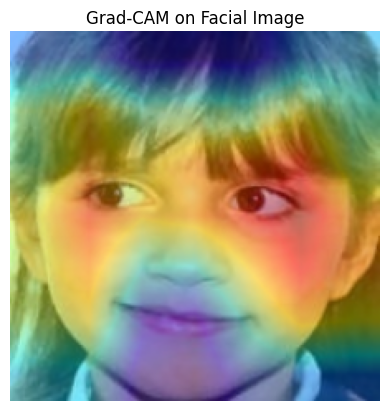

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import cv2

def generate_gradcam(model, img_array, last_conv_layer_name="conv5_block32_concat", class_idx=1):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()[0]

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

# Example usage:
img = cv2.imread("01.jpg")
img_resized = cv2.resize(img, (224, 224))
img_array = np.expand_dims(img_resized / 255.0, axis=0)
heatmap = generate_gradcam(model, img_array)

# Overlay heatmap on original image
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_resized, 0.6, heatmap, 0.4, 0)

plt.imshow(superimposed_img[..., ::-1])
plt.axis('off')
plt.title("Grad-CAM on Facial Image")
plt.show()


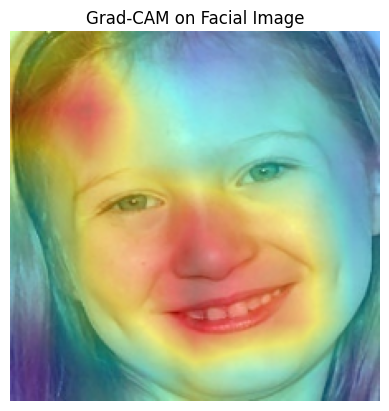

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import cv2

def generate_gradcam(model, img_array, last_conv_layer_name="conv5_block32_concat", class_idx=1):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()[0]

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

# Example usage:
img = cv2.imread("08.jpg")
img_resized = cv2.resize(img, (224, 224))
img_array = np.expand_dims(img_resized / 255.0, axis=0)
heatmap = generate_gradcam(model, img_array)

# Overlay heatmap on original image
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_resized, 0.6, heatmap, 0.4, 0)

plt.imshow(superimposed_img[..., ::-1])
plt.axis('off')
plt.title("Grad-CAM on Facial Image")
plt.show()


In [16]:
# ✅ Evaluate on Test Data
test_loss, test_acc = model.evaluate(test_generator)
print(f"🔥 Test Accuracy: {test_acc:.4f}")
print(f"📉 Test Loss: {test_loss:.4f}")

10/10 [==============================] - 15s 2s/step - loss: 0.9645 - accuracy: 0.8367
🔥 Test Accuracy: 0.8367
📉 Test Loss: 0.9645


In [17]:
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
test_labels = test_generator.classes  # Get true labels from generator
report = classification_report(test_labels, predicted_labels, target_names=['Non_Autistic', 'Autistic'])
print(report)

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 453ms/step
              precision    recall  f1-score   support

Non_Autistic       0.96      0.85      0.90       150
    Autistic       0.87      0.96      0.91       150

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300



In [18]:
predictions[0]

array([7.5508207e-05, 9.9992454e-01], dtype=float32)

In [25]:
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.data import Dataset

# Step 1: Extract all data from the test_generator
all_images = []
all_labels = []

for i in range(len(test_generator)):
    images, labels = test_generator[i]
    all_images.append(images)
    all_labels.append(labels)

# Concatenate all batches
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Step 2: Filter for autism [0, 1] and non-autism [1, 0]
autism_mask = np.all(all_labels == [0, 1], axis=1)
non_autism_mask = np.all(all_labels == [1, 0], axis=1)

autism_images = all_images[autism_mask][:50]
autism_labels = all_labels[autism_mask][:50]

non_autism_images = all_images[non_autism_mask][:50]
non_autism_labels = all_labels[non_autism_mask][:50]

# Step 3: Combine autism first, then non-autism
final_images = np.concatenate([autism_images, non_autism_images], axis=0)
final_labels = np.concatenate([autism_labels, non_autism_labels], axis=0)

# Step 4: Define a new generator from this filtered data
class CustomTestGenerator(Sequence):
    def __init__(self, images, labels, batch_size=32):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.images[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]
        return batch_x, batch_y

# Instantiate the new test generator
filtered_test_generator = CustomTestGenerator(final_images, final_labels, batch_size=32)


In [26]:
# Preview all labels from the custom test generator
all_previewed_labels = []

for i in range(len(filtered_test_generator)):
    _, batch_labels = filtered_test_generator[i]
    all_previewed_labels.append(batch_labels)

# Concatenate all batch labels into a single array
all_labels_array = np.concatenate(all_previewed_labels, axis=0)

# Print shape and first few labels
print("Total Labels Shape:", all_labels_array.shape)
print("First 5 labels:\n", all_labels_array[:5])      # Should be [0, 1] (autism)
print("Last 5 labels:\n", all_labels_array[-5:])      # Should be [1, 0] (non-autism)


Total Labels Shape: (100, 2)
First 5 labels:
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Last 5 labels:
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [27]:
# ✅ Evaluate on Test Data
test_loss1, test_acc1 = model.evaluate(filtered_test_generator)
print(f"🔥 Test Accuracy: {test_acc1:.4f}")
print(f"📉 Test Loss: {test_loss1:.4f}")

/home/collab/Sapthak Codes/Multi/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-05-29 02:39:08.756528: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.9079 - loss: 0.2680
🔥 Test Accuracy: 0.9000
📉 Test Loss: 0.3111


In [28]:
predictions1 = model.predict(filtered_test_generator)

2025-05-29 02:50:22.301899: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step


In [29]:
import numpy as np

# Example: Save a single array
np.save('my_array.npy', predictions1)
